# Dask and XGBoost

In [1]:
%matplotlib inline

The `dask-xgboost` library provides a small wrapper around `dask-xgboost` for passing dask objects to `xgboost`.

In [2]:
import os
import requests
import pandas as pd
import dask.dataframe as dd


if not os.path.exists("SUSY.csv.gz"):
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz"
    r = requests.get(url, stream=True)
    with open("SUSY.csv.gz", "wb") as f:
        for chunk in r.iter_content(chunk_size=2048):
            f.write(chunk)

if not (os.path.exists("susy/train/") and os.path.exists("susy/test")):
    df = pd.read_csv("SUSY.csv.gz", header=None)

    train = df.iloc[:-500000].rename(columns=str)
    test = df.iloc[-500000:].rename(columns=str)

    train = dd.from_pandas(train, npartitions=4)
    test = dd.from_pandas(test, npartitions=4)

    train.to_parquet("susy/test")
    test.to_parquet("susy/train")

As usual, we'll create or connect to a cluster.

In [3]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client()  # connect to cluster 

We've stored the training and test datasets as parquet files.

In [4]:
train = dd.read_parquet("susy/train")
test = dd.read_parquet("susy/test")

y_train = train['0'] 
X_train = train.drop('0', axis=1)

y_test = test['0']
X_test = test.drop('0', axis=1)

X_train, y_train, X_test, y_test = client.persist([X_train, y_train, X_test, y_test])

In [5]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
index,,,,,,,,,,,,,,,,,,
4500000,2.088279,1.556223,-1.159801,2.564809,0.640849,1.341437,1.096579,0.797625,1.381939,-0.200281,2.162097,1.809158,0.742538,2.594079,1.958922,2.399706,0.465633,0.199338
4500001,0.483154,0.293696,-0.272460,0.474080,0.062757,-0.867734,1.142362,0.696387,1.714826,-0.288509,0.403597,0.897979,1.974393,1.888550,0.474009,1.420682,1.107179,0.043890
4500002,0.653066,1.396558,1.325271,0.656052,-1.034418,1.701688,1.034030,-0.227895,1.552204,-0.720430,1.204290,1.152103,0.848940,2.422719,1.227968,1.856319,1.393933,0.059517
4500003,2.212137,0.083248,1.662411,2.775866,0.437338,-0.114064,0.358706,-1.055752,0.141371,0.469900,2.065994,0.905919,0.389112,0.000000,2.056065,0.234328,0.594752,0.060977
4500004,0.578197,-1.303118,-1.496069,0.608464,-1.493001,0.379941,1.005586,-0.598012,1.509509,-0.098402,0.495630,0.813985,1.457386,0.842825,0.565840,0.973772,1.370470,0.127417


In [6]:
y_train.head()

index
4500000    0.0
4500001    0.0
4500002    0.0
4500003    1.0
4500004    0.0
Name: 0, dtype: float64

Let's import the `dask_xboost` library.

In [7]:
import dask_xgboost as dxgb
import xgboost as xgb

You define your model parameters as usual.

In [8]:
params = {'objective': 'binary:logistic'}
bst = dxgb.train(client, params, X_train, y_train)
bst

In [13]:
predictions = dxgb.predict(client, bst, X_test)
predictions = client.persist(predictions)
predictions

Dask Series Structure:
npartitions=4
0          float32
1125000        ...
2250000        ...
3375000        ...
4499999        ...
Name: predictions, dtype: float32
Dask Name: _predict_part, 4 tasks

The `bst` object is just a reguler `xgboost.Booster`, so all the familar methods are available.

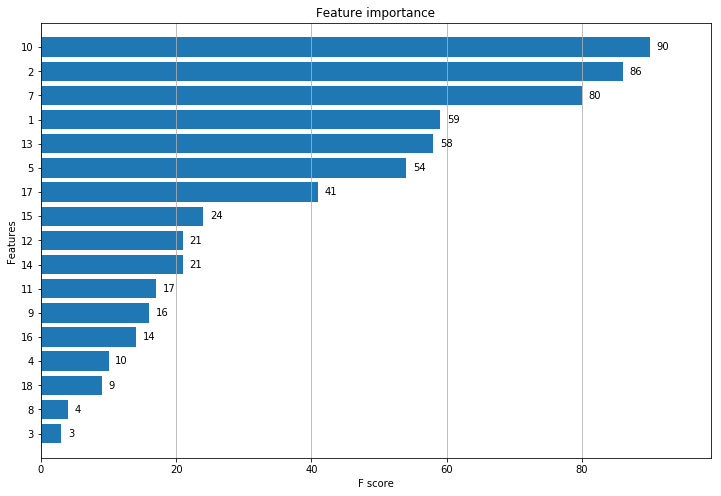

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8)
ax.grid("off", axis="y")

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

The `predictions` object is a `dask.Series`, so it can be used in place of a numpy array in most places.

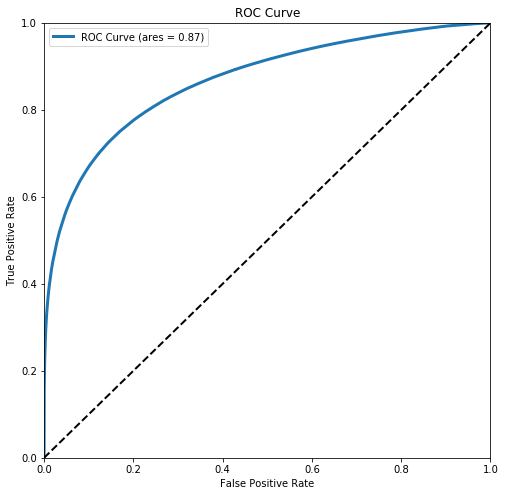

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
fpr, tpr, _ = roc_curve(y_test, predictions)
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (ares = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)

ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();